Lab Assignment Seven: Recurrent Network Architectures
In this lab, you will select a prediction task to perform on your dataset, evaluate a recurrent architecture and tune hyper-parameters. If any part of the assignment is not clear, ask the instructor to clarify. 

This report is worth 10% of the final grade. Please upload a report (one per team) with all code used, visualizations, and text in a rendered Jupyter notebook. Any visualizations that cannot be embedded in the notebook, please provide screenshots of the output. The results should be reproducible using your report. Please carefully describe every assumption and every step in your report.

## Dataset Selection

Select a dataset that is text. That is, the dataset should be text data (or a time series sequence). In terms of generalization performance, it is helpful to have a large dataset of similar sized text documents. It is fine to perform binary classification or multi-class classification. The classification can be "many-to-one" or "many-to-many" sequence classification, whichever you feel more comfortable with. 

describe

## Preparation (3 points total)


[1 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed). Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). Discuss methods of tokenization in your dataset as well as any decisions to force a specific length of sequence. 

In [ ]:
import pandas as pd
df = pd.read_csv('wiki_movie_plots_deduped.csv', index_col=0) 
df.head()

,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
Release Year,,,,,,,
1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


In [ ]:
pd.set_option('display.max_rows', None)
df['Genre'].value_counts()

unknown                                                                              6083
drama                                                                                5964
comedy                                                                               4379
horror                                                                               1167
action                                                                               1098
thriller                                                                              966
romance                                                                               923
western                                                                               865
crime                                                                                 568
adventure                                                                             526
musical                                                                               467
crime dram

In [ ]:
df['Genre'].replace(to_replace=['thriller', 'diaster', 'disaster film', 'action-adventure', 'adventure', 'spy', 'war', 'suspense', 'action thriller'], 
                    value=['action', 'action', 'action', 'action', 'action', 'action','action', 'action', 'action'], 
                    inplace=True)
df.Genre.value_counts()

unknown                                                                              6083
drama                                                                                5964
comedy                                                                               4379
action                                                                               3083
horror                                                                               1167
romance                                                                               923
western                                                                               865
crime                                                                                 568
musical                                                                               467
crime drama                                                                           464
romantic comedy                                                                       461
science fi

In [ ]:
df.drop(['Title', 'Origin/Ethnicity', 'Director', 'Cast', 'Wiki Page'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34886 entries, 1901 to 2017
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Genre   34886 non-null  object
 1   Plot    34886 non-null  object
dtypes: object(2)
memory usage: 817.6+ KB


In [ ]:
df = df.loc[(df['Genre'] == 'drama') | (df['Genre'] == 'comedy') | (df['Genre'] == 'action')]
df['Genre'].value_counts()

drama     5964
comedy    4379
action    3083
Name: Genre, dtype: int64

In [ ]:
from sklearn import preprocessing 

label = preprocessing.LabelEncoder() 
df['Genre']= label.fit_transform(df['Genre']) 

/tmp/ipykernel_81/1673154461.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Genre']= label.fit_transform(df['Genre'])


**Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). Discuss methods of tokenization in your dataset as well as any decisions to force a specific length of sequence.**

[1 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

Accuracy, validation, loss, etc. 

McNemar? look at previous labs for ideas

[1 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your train/test splitting method is a realistic mirroring of how an algorithm would be used in practice. 

We decided on Stratified 5-fold Shuffle Split as we don't have a ton of data to work on.......

Mention imbalance of the classes.

## Modeling (6 points total)

[3 points] Investigate at least two different recurrent network architectures (perhaps LSTM and GRU). Alternatively, you may also choose one recurrent network and one convolutional network. Be sure to use an embedding layer (try to use a pre-trained embedding, if possible). Adjust hyper-parameters of the networks as needed to improve generalization performance (train a total of at least four models). Discuss the performance of each network and compare them.


Similar to your demo in class, we will use the GLoVe pre-trained for our embedding layer to avoid any issues with unfair comparisons. This should also be faster, as we won't have to train our own layer. 

In [ ]:
%%time
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

NUM_TOP_WORDS = None # use entire vocabulary!
MAX_ART_LEN = 1000 # maximum and minimum number of words

#tokenize the text
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(df.Plot)
# save as sequences with integers replacing words
sequences = tokenizer.texts_to_sequences(df.Plot)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

y_ohe = keras.utils.to_categorical(df.Genre)
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_ohe.shape)
print(np.max(X))


2022-12-14 21:33:37.615741: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-14 21:33:37.729980: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-14 21:33:37.739079: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-14 21:33:37.739099: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

Here we show the different classes from our data, since we only used the most common movie genres, the balancing between the number of instances in each class is a little off. Nevertheless, for the purposes of this model and demonstration it should be sufficient.

X Shape: (13426, 1000) Label Shape: (13426, 3)


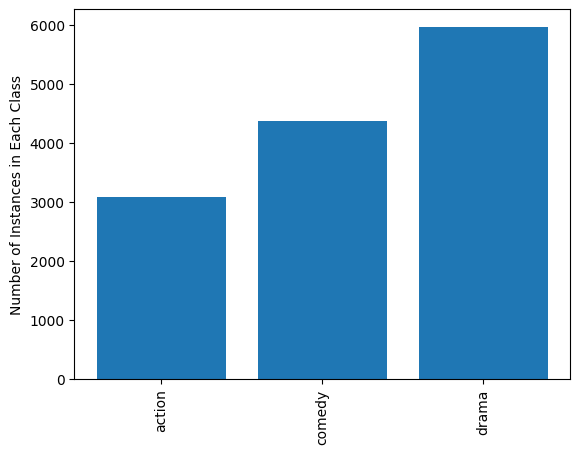

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt
from matplotlib import pyplot as plt
%matplotlib inline

# Split it into train / test subsets
# X_train, X_test, y_train_ohe, y_test_ohe = train_test_split(X, y_ohe, test_size=0.2,
#                                                             stratify=df.Genre, 
#                                                             random_state=42)
NUM_CLASSES = 3

# print some stats of the data
print("X Shape:",X.shape, "Label Shape:", y_ohe.shape)
uniq_classes = np.sum(y_ohe,axis=0)
plt.bar(list(range(3)),uniq_classes)
plt.xticks(list(range(3)), ['action', 'comedy', 'drama'], rotation='vertical')
plt.ylabel("Number of Instances in Each Class")
plt.show()

Now lets save the word embeddings from before

In [ ]:
%%time
EMBED_SIZE = 100
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('glove.6B.100d.txt')
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be ALL-ZEROS
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

print("Embedding Shape:",embedding_matrix.shape, "\n",
      "Total words found:",found_words, "\n",
      "Percentage:",100*found_words/embedding_matrix.shape[0])

Found 400000 word vectors.
Embedding Shape: (96972, 100) 
 Total words found: 65488 
 Percentage: 67.53289609371778
CPU times: user 6.3 s, sys: 239 ms, total: 6.53 s
Wall time: 6.56 s


In [ ]:
from tensorflow.keras.layers import Embedding

# save this embedding now
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],# here is the embedding getting saved
                            input_length=MAX_ART_LEN,
                            trainable=False)

In [ ]:
no_epochs = 6

### LSTM Model

Now lets create our LSTM Recurrent neural network!

**Default Hyper-Parameters**

Our first variation will be using the default hyper-parameters of the rmsprop optimizer and with 35 neruons in the RNN layer.

First we will create a function for creating and compiling our model. This will be useful when we run the loop for the stratified shuffle split cross validation.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

def create_lstm_model(opt='rmsprop', neurons=35):
    rnn_lstm = Sequential()
    rnn_lstm.add(embedding_layer)
    rnn_lstm.add(LSTM(neurons,dropout=0.2, recurrent_dropout=0.2))
    rnn_lstm.add(Dense(NUM_CLASSES, activation='sigmoid'))
    rnn_lstm.compile(loss='categorical_crossentropy', 
                optimizer=opt, 
                metrics=['accuracy'])
    return rnn_lstm

model = create_lstm_model()
print(model.summary())


2022-12-14 21:45:33.270716: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-14 21:45:33.270749: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-14 21:45:33.270766: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-b660344e-fe98-4685-abd4-4426827ffe7d): /proc/driver/nvidia/version does not exist
2022-12-14 21:45:33.271061: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Model: "sequential"
____________________________________________

Here we created a function for training the model with the number of epochs stated previously. This function then returns the history of the fit function that was called. 

In [ ]:
def train_model(model, X_train, y_train, X_test, y_test):
    # history_lstm = []
    tmp = model.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), 
                       epochs=no_epochs, 
                       batch_size=64)
    # history_lstm.append( tmp )
    return tmp


Epoch 1/3
168/168 [==============================] - 577s 3s/step - loss: 0.9974 - accuracy: 0.4916 - val_loss: 0.9243 - val_accuracy: 0.5614
Epoch 2/3
168/168 [==============================] - 565s 3s/step - loss: 0.9490 - accuracy: 0.5412 - val_loss: 0.9193 - val_accuracy: 0.5495
Epoch 3/3
168/168 [==============================] - 522s 3s/step - loss: 0.9154 - accuracy: 0.5721 - val_loss: 0.8995 - val_accuracy: 0.5894


Now to the good stuff! Here is how we run the model using the stratified shuffle split that we determined as the best method for splitting our data. We used a loop to run through each of the 5 folds, all while saving the history and model for each fold. Then we averaged the history for each fold for visualizing later on.

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2,
                             random_state=012)

# we will store the history for each fold, the pick the one with the best performance
lstm_history = []
scores_lstm = []

# idea for saving models:
model_list_lstm = []

for index, (train_idx, test_idx) in enumerate(skf.split(X, y_ohe)):
    print "Training on fold " + str(index+1) + "/5..."
    # Generate batches from indices
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    fold_history = []

    # Clear model, and create it-- can we save models? look into it pls, maybe save in array or smth, model 1-10
    model = None
    model = create_lstm_model()
    
    # train model
    tmp = train_model(model, X_train, y_train, X_test, y_test)

    # save model weights for future runs and save history 
    model_list_lstm.append(model) #for saving models, dont know if this will work
    fold_history.append(tmp)
    lstm_history.append(fold_history)

    y_hat = model.predict(X_test)
    scores_lstm.append(accuracy_score(y_test, y_hat))


Since our model hasn't converged yet, lets run it for a few more epochs! We will again save the new newly updated models and the history for this additional set of epochs.

In [ ]:
# code if we want to run for more epochs without starting over- just copy and paste
no_epochs = 6
# epoch_history = []

for index, (train_idx, test_idx) in enumerate(skf.split(X, y_ohe)):
    print "Training on fold " + str(index+1) + "/5..."
    # Generate batches from indices
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # use saved model from previous run, hopefully this saves all the weights and stuff
    model = model_list_lstm[index]
    
    # train model
    tmp = train_model(model, X_train, y_train, X_test, y_test)

    # save model again and save history
    model_list_lstm[index] = model #for saving models, dont know if this will work

    y_hat = model.predict(X_test)
    scores_lstm[index] = accuracy_score(y_test, y_hat)
    
    lstm_history[index].append(tmp)


Lets see the performance of each of the models to see which one is best.

In [ ]:
plt.bar([1,2,3,4,5],scores_lstm)
plt.xticks([1,2,3,4,5],['1','2','3','4','5'])
plt.show()

It seems that model [PICK ONE] performs the best,  lets visualize the loss and accuracy for this LSTM model.

In [ ]:
# [1,0,2,1]

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(lstm_history[1]['accuracy'])
plt.plot(lstm2_history[0]['accuracy'])
plt.plot(gru_history[2]['accuracy'])
plt.plot(gru2_history[1]['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(122)
plt.plot(lstm_history[1]['val_loss'])
plt.plot(lstm2_history[0]['val_loss'])
plt.plot(gru_history[2]['val_loss'])
plt.plot(gru2_history[1]['val_loss'])
plt.title('model validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


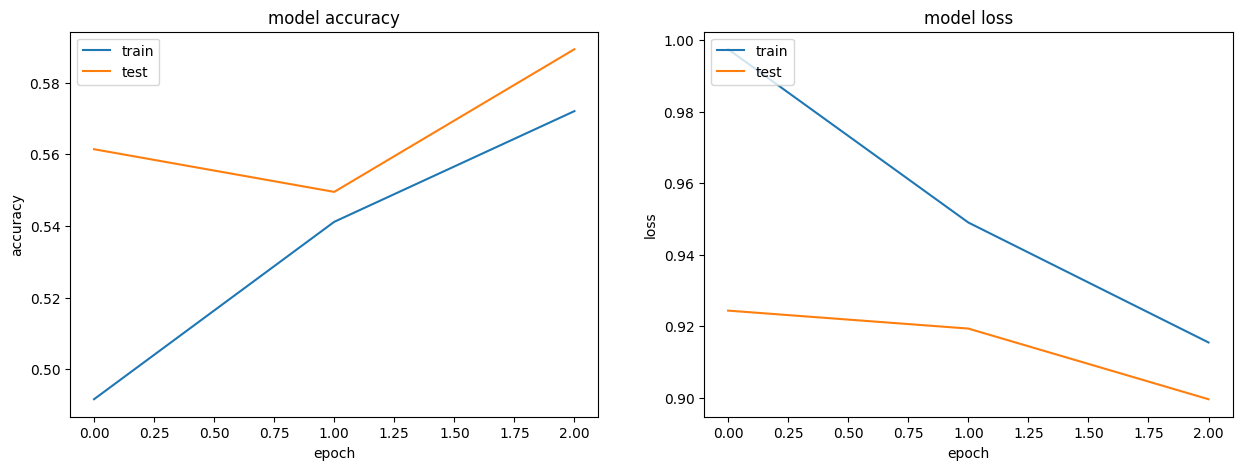

In [ ]:
best_fold = 0

# combine all the LSTM history from training together
combined = dict()
for key in ['accuracy','val_accuracy','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in lstm_history[best_fold]])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['accuracy'])
plt.plot(combined['val_accuracy'])
plt.title('lstm model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('lstm model validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



Cool! Now lets create a second LSTM network and see how they compare. (should we change random state values???)

**Varying optimizer and hyperparameters**

For hyperparameter tuning, lets use a different optimizer, Adam, and with a higher number of RNN neurons. 

In [ ]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2,
                             random_state=012)

opt = Adam(lr=0.001, epsilon=0.001, clipnorm=1.0)
neurons = 50

# we will store the history for each fold, then average them together
# epoch_history = []
lstm2_history = []
scores_lstm2 = []

# idea for saving models:
model_list_lstm2 = []

for index, (train_idx, test_idx) in enumerate(skf.split(X, y_ohe)):
    print "Training on fold " + str(index+1) + "/5..."
    # Generate batches from indices
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    fold_history = []

    # Clear model, and create it-- can we save models? look into it pls, maybe save in array or smth, model 1-10
    model = None
    model = create_lstm_model(opt, neurons)
    
    # train model
    tmp = train_model(model, X_train, y_train, X_test, y_test)

    # save model weights for future runs and save history 
    model_list_lstm2.append(model) #for saving models, dont know if this will work

    y_hat = model.predict(X_test)
    scores_lstm2.append(accuracy_score(y_test, y_hat))

    fold_history.append(tmp)
    lstm2_history.append(fold_history)



Since our model hasn't converged yet, lets run it for a few more epochs!

In [ ]:
# code if we want to run for more epochs without starting over- just copy and paste
no_epochs = 6

for index, (train_idx, test_idx) in enumerate(skf.split(X, y_ohe)):
    print "Training on fold " + str(index+1) + "/5..."
    # Generate batches from indices
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # use saved model from previous run, hopefully this saves all the weights and stuff
    model = model_list_lstm2[index]
    
    # train model
    tmp = train_model(model, X_train, y_train, X_test, y_test)

    # save model again and save history
    model_list_lstm2[index] = model #for saving models, dont know if this will work
    
    y_hat = model.predict(X_test)
    scores_lstm2[index] = accuracy_score(y_test, y_hat)
    
    lstm2_history[index].append(tmp)


Lets see the performance of each of the models to see which one is best.

In [ ]:
plt.bar([1,2,3,4,5],scores_lstm2)
plt.xticks([1,2,3,4,5],['1','2','3','4','5'])
plt.show()

Now let's visualize the loss and accuracy for our second LSTM model.

In [ ]:
best_fold = 0

# combine all the LSTM history from training together
combined = dict()
for key in ['accuracy','val_accuracy','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in lstm2_history[best_fold]])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['accuracy'])
plt.plot(combined['val_accuracy'])
plt.title('lstm2 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('lstm2 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


### GRU Model

**Default Hyper-Parameters**

Here is a function for creating the GRU model and compiling it. 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

def create_gru_model(opt='rmsprop', neurons=35):
    rnn_gru = Sequential()
    rnn_gru.add(embedding_layer)
    rnn_gru.add(GRU(neurons,dropout=0.2, recurrent_dropout=0.2))
    rnn_gru.add(Dense(NUM_CLASSES, activation='sigmoid'))
    rnn_gru.compile(loss='categorical_crossentropy', 
                optimizer=opt, 
                metrics=['accuracy'])
    return rnn_gru

model = create_gru_model()
print(model.summary())

2022-12-14 07:08:08.917969: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-14 07:08:08.918004: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-14 07:08:08.918021: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-b660344e-fe98-4685-abd4-4426827ffe7d): /proc/driver/nvidia/version does not exist
2022-12-14 07:08:08.918311: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


NameError: name 'embedding_layer' is not defined

Since we determined that Stratified shuffle split is the best method for our dividing our data, we will use a loop for each fold, similar to what we did for our LSTM model.

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2,
                             random_state=012) 

# we will store the history for each fold, then average them together
gru_history = []
scores_gru = []

# idea for saving models:
model_list_gru = []

for index, (train_idx, test_idx) in enumerate(skf.split(X, y_ohe)):
    print "Training on fold " + str(index+1) + "/5..."
    # Generate batches from indices
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    fold_history = []

    # Clear model, and create it-- can we save models? look into it pls, maybe save in array or smth, model 1-10
    model = None
    model = create_gru_model()
    
    # train model
    tmp = train_model(model, X_train, y_train, X_test, y_test)

    # save model weights for future runs and save history 
    model_list_gru.append(model) #for saving models, dont know if this will work
    fold_history.append(tmp)
    gru_history.append(fold_history)

    # save scores
    y_hat = model.predict(X_test)
    scores_gru.append(accuracy_score(y_test, y_hat))



In [ ]:
t = 4.3 /np.sqrt(3)
e = (1-scores_lstm)-(1-scores_lstm2)-(1-scores_gru)-(1-scores_gru2)
stdtot = np.std(e)
dbar = np.mean(e)
print('Range of:', dbar-t*stdtot,dbar+t*stdtot)

print('Mean errors:', np.mean(1-scores_lstm), np.mean(1-scores_lstm2, np.mean(1-scores_gru), np.mean(1-scores_gru2))


print('Model 1 has statistically the best performance with 95% confidence as it has the lowest error rate')

Lets run the model for more epochs since we can see that it hasn't converged yet!

In [ ]:
# code if we want to run for more epochs without starting over- just copy and paste
no_epochs = 6

for index, (train_idx, test_idx) in enumerate(skf.split(X, y_ohe)):
    print "Training on fold " + str(index+1) + "/5..."
    # Generate batches from indices
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # use saved model from previous run, hopefully this saves all the weights and stuff
    model = model_list_gru[index]
    
    # train model
    tmp = train_model(model, X_train, y_train, X_test, y_test)

    # save model again and save history
    model_list_gru[index] = model #for saving models, dont know if this will work; bet its slow tho
    gru_history[index].append(tmp)

    y_hat = model.predict(X_test)
    scores_gru[index] = accuracy_score(y_test, y_hat)


Now lets choose the best fold!

In [ ]:
plt.bar([1,2,3,4,5],scores_gru)
plt.xticks([1,2,3,4,5],['1','2','3','4','5'])
plt.show()

Let's visualize both the GRU accuracy and loss curves.

In [ ]:
import numpy as np
from sklearn.metrics import roc_curve
a = np.array([[0.2, 0.3, 0.4],[0.1, 0.3, 0.5],[0.2, 0.6, 0.2],[0.1, 0.1, 0.8],[0.4, 0.3, 0.2]])
b = [0,1,2,1,0]

results = model.evaluate(a, b, batch_size=128)
print(results)

# classes = np.unique(b)
# print(classes)
# for j in classes:
#     fpr, tpr, thresholds = roc_curve(b, a[:,j], pos_label=j)
#     print(fpr)
#     print(tpr)
#     print(thresholds)

NameError: name 'model' is not defined

In [ ]:
best_fold = 0

# combine all the GRU history from training together
combined = dict()
for key in ['accuracy','val_accuracy','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in gru_history[best_fold]])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['accuracy'])
plt.plot(combined['val_accuracy'])
plt.title('gru model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('gru model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


**Varying optimizer and hyperparameters**

Similar to the LSTM variation, here we will vary the optimizer that is used and increase the number of neurons in the RNN layer to 50.

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2,
                             random_state=012) 

opt = Adam(lr=0.001, epsilon=0.001, clipnorm=1.0)
neurons = 50

# we will store the history for each fold, then average them together
# epoch_history = []
gru2_history = []
scores_gru2 = []

# idea for saving models:
model_list_gru2 = []

for index, (train_idx, test_idx) in enumerate(skf.split(X, y_ohe)):
    print "Training on fold " + str(index+1) + "/5..."
    # Generate batches from indices
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    fold_history = []

    # Clear model, and create it-- can we save models? look into it pls, maybe save in array or smth, model 1-10
    model = None
    model = create_gru_model(opt, neurons)
    
    # train model
    tmp = train_model(model, X_train, y_train, X_test, y_test)

    # save model weights for future runs and save history 
    model_list_gru2.append(model) #for saving models, dont know if this will work
    # epoch_history.append(tmp)
    fold_history.append(tmp)
    gru2_history.append(fold_history)

    # save scores
    y_hat = model.predict(X_test)
    scores_gru2.append(accuracy_score(y_test, y_hat))


# # average all the histories from each fold so we just one one combined history 
# gru_history = dict()
# for key in ['accuracy','val_accuracy','loss','val_loss']:
#     gru_history[key] = np.average([x.history[key] for x in epoch_history], axis=0)

# # save histories for this set of epochs
# gru2_history_all.append(gru_history)

Lets run for a few more epochs just in case

In [ ]:
# code if we want to run for more epochs without starting over- just copy and paste
no_epochs = 6
# epoch_history = []

for index, (train_idx, test_idx) in enumerate(skf.split(X, y_ohe)):
    print "Training on fold " + str(index+1) + "/5..."
    # Generate batches from indices
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # use saved model from previous run, hopefully this saves all the weights and stuff
    model = model_list_gru2[index]
    
    # train model
    tmp = train_model(model, X_train, y_train, X_test, y_test)

    # save model again and save history
    model_list_gru2[index] = model #for saving models, dont know if this will work; bet its slow tho
    # epoch_history.append(tmp)
    gru2_history[index].append(tmp)

    # save scores
    y_hat = model.predict(X_test)
    scores_gru[index] = accuracy_score(y_test, y_hat)

# # average all the histories from each fold so we just one one combined history 
# gru_history = dict()
# for key in ['accuracy','val_accuracy','loss','val_loss']:
#     gru_history[key] = np.average([x.history[key] for x in epoch_history], axis=0)

# # save histories for new set of epochs
# gru2_history_all.append(gru_history)

Time to choose best fold!

In [ ]:
plt.bar([1,2,3,4,5],scores_gru2)
plt.xticks([1,2,3,4,5],['1','2','3','4','5'])
plt.show()

Now lets visualize for the final model!

In [ ]:
best_fold = 0

# combine all the GRU2 history from training together
combined = dict()
for key in ['accuracy','val_accuracy','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in gru2_history[best_fold]])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['accuracy'])
plt.plot(combined['val_accuracy'])
plt.title('gru2 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('gru2 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


Test on using Keras with sklearn pipeline:

In [ ]:
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train_idx, test_idx) in enumerate(sss.split(X, y_ohe)):
    y_hat = model_list_lstm[i].predict(X.test[test_idx])

    perclass_mean_tpr = 0.0
    roc_auc = 0
    classes = np.unique(y_test[test_idx])
    # get the mean fpr and tpr, per class
    for j in classes:
        fpr, tpr, thresholds = roc_curve(y_test[test],
                                         np.argmax(y_hat, axis=1))
        perclass_mean_tpr += interp(mean_fpr, fpr, tpr)
        perclass_mean_tpr[0] = 0.0
        roc_auc += auc(fpr, tpr)
        
    perclass_mean_tpr /= len(classes)
    roc_auc /= len(classes)
    mean_tpr += perclass_mean_tpr
    plt.plot(mean_fpr,perclass_mean_tpr,'--',lw=1,label='Mean Class ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))
    
mean_tpr /= K
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr,perclass_mean_tpr,'k-',lw=2,label='Total Mean ROC (area = %0.2f)'
                   % (mean_auc))
plt.legend(loc='best')
plt.grid()

In [ ]:
for i,(train_idx, test_idx) in enumerate(sss.split(X, y_ohe)):

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y_ohe[train_idx], y_ohe[test_idx] 
    results = model_list_lstm[i].evaluate(X_test, y_test, batch_size=64)
    print(results)

[1 points] Fall 2022 Skip this part of the rubric; You will receive full credit. Using the best RNN parameters and architecture, add a second recurrent chain to your RNN. The input to the second chain should be the output sequence of the first chain. Visualize the performance of training and validation sets versus the training iterations. 

**Yay!**

However, if we did wish to do that, all we would have to do is save the outputs of every recurrent cell in a new input vector. This can be done by setting the return_state flag within the model function to **True**. This would then lead the model to return the output state of every cell in the network as a list.  Then we would create another RNN layer where we would use this new list as the input! After that, we would put it into the dense layer, similar to before, to get our prediction.

[2 points] Use the method of train/test splitting and evaluation criteria that you argued for at the beginning of the lab. Visualize the results of all the RNNs you trained.  Use proper statistical comparison techniques to determine which method(s) is (are) superior.  

Have not started this-- no idea how to get yhat from stratified shuffle split

he talked about ROC curves and ksplit in this notebook, might help: https://github.com/eclarson/MachineLearningNotebooks/blob/master/09.%20Evaluation.ipynb

In [ ]:
# this operation can take time 
yhat_lstm = lstm_model.predict(X_test)
yhat_gru = gru_model.predict(X_test)

In [ ]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
%matplotlib inline

acc = [mt.accuracy_score(y_test,np.round(yhat_lstm)),
       mt.accuracy_score(y_test,np.round(yhat_gru)),
      ]

plt.bar([1,2],acc)
plt.xticks([1,2],['LSTM','GRU'])
plt.show()

## Exceptional Work (1 points total)
Fall 2022 Skip this part of the rubric; You will receive full credit for the exceptional credit.

**Yay!**



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b660344e-fe98-4685-abd4-4426827ffe7d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>